# Diffusion Model Hands-On Tutorial

**Sangwoong Yoon** (AI Research Fellow @ KIAS; http://swyoon.github.io )

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/swyoon/kias-hyu-diffusion-tutorial-2023/blob/main/diffusion_model_hands_on.ipynb)

**Abstract**

> Today, we will study a minimal working example of [Denoising Diffusion Probabilistic Model (DDPM); Ho et al., 2020](https://arxiv.org/abs/2006.11239).
> Instead of reproducing fancy results from large-scale models, we shall focus on understanding what is exactly going on inside a very small model.
> We will run a vanilla DDPM on 2D datasets and investigate when it works well and when it doesn't.



**Table of Contents**

1. Data Generation
2. Diffusion
3. DDPM
4. Neural Networks
5. Training
6. Performance Evaluation

**Exercise**

* Vary the following variables and see if the performance remains the same:
    * dataset
    * the number of diffusion time steps
    * beta (sigma) schedule
    * scale of data
    * the number of diffusion time steps

**Further Reading**

* https://github.com/openai/guided-diffusionhttps://github.com/openai/guided-diffusion
* https://github.com/CompVis/latent-diffusionhttps://github.com/CompVis/latent-diffusion

In [1]:
device = 'cpu'

In [2]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Dataset Generation

In [3]:
dataset = '8gaussians'

In [4]:
'''
Synthetic distributions from https://github.com/nicola-decao/BNAF/
'''
def sample2d(data, batch_size=200, scale_factor=1.):
    rng = np.random.RandomState()

    if data == '8gaussians':
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        dataset *= scale_factor
        return dataset

    elif data == '2spirals':
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        x *= scale_factor
        return x

    elif data == 'checkerboard':
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        dataset = np.concatenate([x1[:, None], x2[:, None]], 1) * 2
        dataset *= scale_factor
        return dataset

    else:
        raise RuntimeError

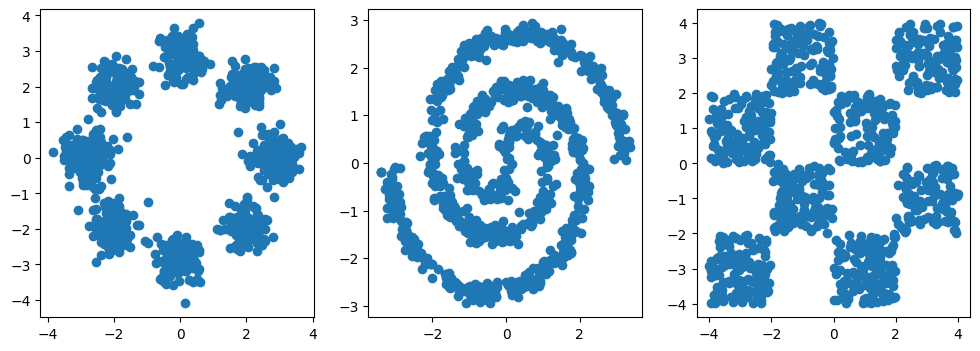

In [5]:
'''visualize datasets'''
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
x = torch.tensor(sample2d('8gaussians', batch_size=1000, scale_factor=1.))
axs[0].scatter(x[:,0], x[:,1])
x = torch.tensor(sample2d('2spirals', batch_size=1000, scale_factor=1.))
axs[1].scatter(x[:,0], x[:,1])
x = torch.tensor(sample2d('checkerboard', batch_size=1000, scale_factor=1.))
axs[2].scatter(x[:,0], x[:,1])

## 2. Diffusion

$$
x_{t} = \sqrt{1-\sigma_t^2} \cdot x_{t-1} + \sigma_t \epsilon, \epsilon \sim \mathcal{N}(0, I)
$$

We will mainly write with respect to $\beta_t = \sigma_t^2$.

In the paper, $t \in \{1,\ldots,T\}$.  
However, computers (and also computer scientists) counts from 0. So keep in mind that the index 0 corresponds to $t=1$.

In [6]:
'''
Define a sequence of sigma_t's.
'''
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "constant":
        betas = torch.ones(n_timesteps) * start
    return betas


def extract(var, t, x):
    shape = x.shape
    out = torch.gather(var, 0, t.to(var.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape).to(x.device)


In [7]:
"""initialize diffusion-related constant"""
beta_schedule = 'linear'
n_timesteps = 1000
beta_start, beta_end = 1e-3, 1e-2
betas = make_beta_schedule(
    schedule=beta_schedule,
    n_timesteps=n_timesteps,
    start=beta_start,
    end=beta_end,
)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [8]:
def q_sample(x_start, t):
    """
    Diffuse the data (t == 0 means diffused for 1 step)
    """
    global alphas_bar_sqrt, one_minus_alphas_bar_sqrt
    noise = torch.randn(*x_start.shape, device=x_start.device)
    x_t = extract(alphas_bar_sqrt, t, x_start) * x_start + extract(one_minus_alphas_bar_sqrt, t, x_start) * noise
    return x_t

def q_sample_progressive(x_0, n_timesteps):
    """Generate a full sequence of perturbed samples"""
    x_preds = []
    for t in range(n_timesteps):
        t_now = torch.ones(x_0.shape[0], device=x_0.device, dtype=torch.long) * t
        x_t = q_sample(x_0, t_now)
        x_preds.append(x_t)
    x_preds = torch.stack(x_preds, dim=0)
    return x_preds

(-4.0, 4.0)

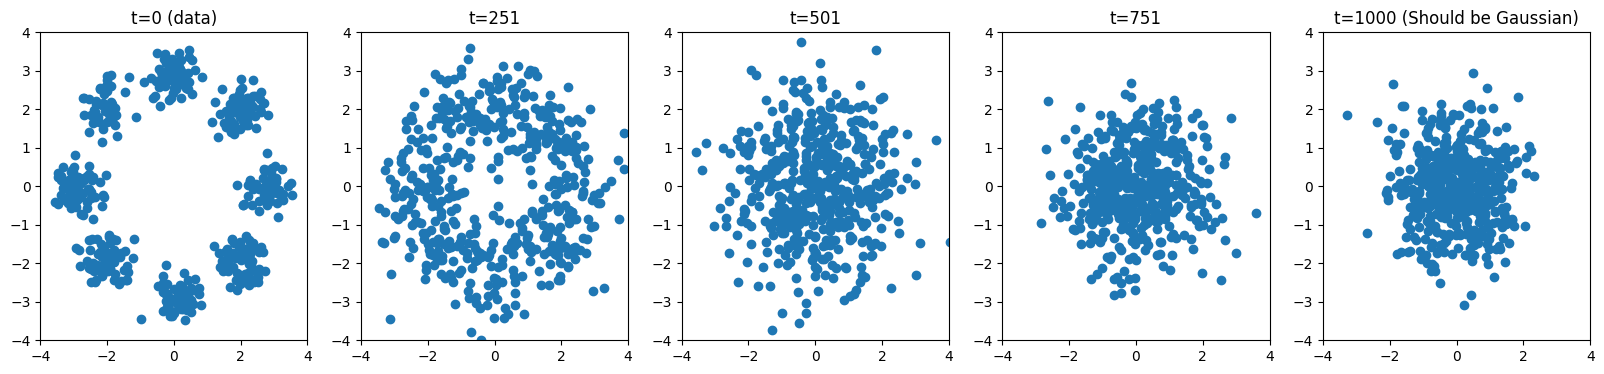

In [9]:
'''visualize diffusion process'''
x = torch.tensor(sample2d(dataset, batch_size=500))
x_diffused = q_sample_progressive(x, n_timesteps)


fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
axs[0].scatter(x[:,0], x[:,1])
axs[0].set_title('t=0 (data)')
axs[0].set_xlim([-4,4])
axs[0].set_ylim([-4,4])

for i_plot in [1, 2, 3]:
    t = n_timesteps // 4 * i_plot
    xx = x_diffused[t]
    axs[i_plot].scatter(xx[:,0], xx[:,1])
    axs[i_plot].set_title(f't={t+1}')
    axs[i_plot].set_xlim([-4,4])
    axs[i_plot].set_ylim([-4,4])

xx = x_diffused[-1]
axs[4].scatter(xx[:,0], xx[:,1])
axs[4].set_title(f't={n_timesteps} (Should be Gaussian)')
axs[4].set_xlim([-4,4])
axs[4].set_ylim([-4,4])

## 3. DDPM

![](https://github.com/swyoon/kias-hyu-diffusion-tutorial-2023/blob/main/ddpm_algorithm.png?raw=1)

In [10]:
class DDPM(nn.Module):
    """a minimal working DDPM"""

    def __init__(
        self,
        sampler,
        n_timesteps,
        sample_shape,
        beta_schedule="sigmoid",
        beta_start=1e-5,
        beta_end=1e-2,
    ):
        """
        sampler: a diffusion-like sampler. nn.Module.
        value: value function. nn.Module.
        n_timesteps: number of timesteps
        sample_shape: shape of the samples

        <Diffusion parameters>
        beta_schedule: diffusion noise shcedule. 'linear', 'quad', 'sigmoid', 'constant'
        reg_vel: velocity regularization.
        ddpm_like: if True, a sample is generated via diffusion-like update rule.
            x_{t-1} = 1/sqrt{alpha_t} (x_{t} - (1-alpha_t/sqrt{1-bar{alpha}_t}) * net(x_t,t)) + sigma_t * eps_t,
            if False, x_{t-1} = x_t - net(x_t,t) + sigma_t * eps_t.
        """
        super().__init__()
        betas = make_beta_schedule(
            schedule=beta_schedule,
            n_timesteps=n_timesteps,
            start=beta_start,
            end=beta_end,
        )
        self.register_buffer("betas", betas)
        self.init_beta()
        self.sampler = sampler
        self.sample_shape = sample_shape
        self.n_timesteps = n_timesteps

    def init_beta(self):
        """initialize DDPM related constants"""
        betas = self.betas
        alphas = 1 - betas
        alphas_prod = torch.cumprod(alphas, 0)
        alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
        alphas_bar_sqrt = torch.sqrt(alphas_prod)
        one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
        one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_prod", alphas_prod)
        self.register_buffer("alphas_prod_p", alphas_prod_p)
        self.register_buffer("alphas_bar_sqrt", alphas_bar_sqrt)
        self.register_buffer("one_minus_alphas_bar_log", one_minus_alphas_bar_log)
        self.register_buffer("one_minus_alphas_bar_sqrt", one_minus_alphas_bar_sqrt)

    def sample_step(self, x, t, no_var=False, langevin=False, reward=None):
        """
        perform one-step sampling.

        if self.ddpm_like is True, a sample is generated via diffusion-like update rule.
            x_{t-1} = 1/sqrt{alpha_t} * (x_{t} - (1-alpha_t/sqrt{1-bar{alpha}_t}) * net(x_t,t)) + sigma_t * eps_t,
            if False, x_{t-1} = x_t - net(x_t,t) + sigma_t * eps_t.

        no_var: if True, no noise is added. usually for debugging.
        langevin: decide direction based on the direction of the gradient of the reward.
        reward: required for langevin=True
        """
        device = x.device
        t = process_single_t(x, t)
        eps_theta = self(x, t)

        eps_factor = (1 - extract(self.alphas, t, x)) / extract(
            self.one_minus_alphas_bar_sqrt, t, x
        )
        mean = (1 / extract(self.alphas, t, x).sqrt()) * (
            x - (eps_factor * eps_theta)
        )

        z = torch.randn_like(x)
        sigma_t = extract(self.betas, t, x).sqrt()
        if no_var:
            sample = mean
        else:
            sample = mean + sigma_t * z
        dist = Normal(mean, sigma_t)
        log_prob = dist.log_prob(sample.detach()).sum(-1)
        return {
            "sample": sample,
            "log_prob": log_prob,
            "vel": eps_theta,
            "mean": mean,
            "sigma": sigma_t,
        }

    def sample(self, n_sample, device="cpu", no_var=False):
        x = torch.randn(n_sample, *self.sample_shape).to(device)
        l_x = [x]
        l_vel = []
        log_probs = []

        for t in reversed(range(self.n_timesteps)):
            t = torch.tensor([t]).to(device)
            d_step = self.sample_step(x, t, no_var=no_var)
            x, vel, log_prob, mu, sigma = (
                d_step["sample"],
                d_step["vel"],
                d_step["log_prob"],
                d_step["mean"],
                d_step["sigma"],
            )
            log_probs.append(log_prob)
            l_x.append(x)
            l_vel.append((vel**2).view(len(x), -1).sum(-1))

        log_prob = torch.stack(log_probs, dim=1)  # N x T
        d_sample = {
            "sample": x,
            "l_sample": l_x,
            "log_prob": log_prob,
        }
        return d_sample

    def log_prob(self, l_x):
        """evaluate policy probability given trajectory"""
        assert len(l_x) == self.n_timesteps + 1
        l_log_prob = []
        for t, x in zip(reversed(range(self.n_timesteps)), l_x):
            if t != self.n_timesteps - 1:  # skip x_T
                log_prob = Normal(d_step["mean"], d_step["sigma"]).log_prob(x.detach()).sum(-1)
                l_log_prob.append(log_prob)
            d_step = self.sample_step(x.detach(), t)
        x_last = l_x[-1]
        log_prob = Normal(d_step["mean"], d_step["sigma"]).log_prob(x_last.detach()).sum(-1)
        l_log_prob.append(log_prob)
        return torch.stack(l_log_prob, dim=1)  # N x T

    def forward(self, x, t):
        return self.sampler(x, t)

    def train_step_diffusion(self, x, opt):
        opt.zero_grad()
        loss = self.noise_estimation_loss(x)
        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), 1)
        opt.step()
        d_train = {"loss": loss.item()}
        return d_train

    def noise_estimation_loss(self, x_0):
        batch_size = x_0.shape[0]
        # Select a random step for each example
        t = torch.randint(0, self.n_timesteps, size=(batch_size,))
        # x0 multiplier
        a = extract(self.alphas_bar_sqrt, t, x_0)
        # eps multiplier
        am1 = extract(self.one_minus_alphas_bar_sqrt, t, x_0)
        e = torch.randn_like(x_0)
        # model input
        x = x_0 * a + e * am1
        output = self(x, t)
        return (e - output).square().mean()

## 4. Neural Networks

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConditionalLinear(nn.Module):
    """from https://github.com/UW-Madison-Lee-Lab/SFT-PG/blob/main/toy_exp/models.py
    Original source seems to be https://github.com/acids-ircam/diffusion_models

    prediction from x given conditional information y"""
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()
        torch.nn.init.xavier_normal_(self.lin.weight)

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out


class ConditionalModel(nn.Module):
    """modified from https://github.com/UW-Madison-Lee-Lab/SFT-PG/blob/main/toy_exp/models.py"""
    def __init__(self, in_dim, out_dim, n_steps, n_hidden=128):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(in_dim, n_hidden, n_steps)
        self.lin2 = ConditionalLinear(n_hidden, n_hidden, n_steps)
        self.lin3 = ConditionalLinear(n_hidden, n_hidden, n_steps)
        self.lin4 = nn.Linear(n_hidden, out_dim)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)



In [12]:
"""
Positional embedding for time
"""

# Fully Connected Network
def get_activation(s_act):
    if s_act == 'relu':
        return nn.ReLU(inplace=True)
    elif s_act == 'sigmoid':
        return nn.Sigmoid()
    elif s_act == 'softplus':
        return nn.Softplus()
    elif s_act == 'linear':
        return None
    elif s_act == 'tanh':
        return nn.Tanh()
    elif s_act == 'leakyrelu':
        return nn.LeakyReLU(0.2, inplace=True)
    elif s_act == 'softmax':
        return nn.Softmax(dim=1)
    elif s_act == 'swish':
        return nn.SiLU(inplace=True)
    else:
        raise ValueError(f'Unexpected activation: {s_act}')


class FCNet(nn.Module):
    """fully-connected network"""
    def __init__(self,
            in_dim,
            out_dim,
            l_hidden=(50,),
            activation='sigmoid',
            out_activation='linear',
            bias=True):
        super().__init__()
        l_neurons = tuple(l_hidden) + (out_dim,)
        if isinstance(activation, str):
            activation = (activation,) * len(l_hidden)
        activation = tuple(activation) + (out_activation,)

        l_layer = []
        prev_dim = in_dim
        for i_layer, (n_hidden, act) in enumerate(zip(l_neurons, activation)):
            l_layer.append(nn.Linear(prev_dim, n_hidden, bias=bias))
            act_fn = get_activation(act)
            if act_fn is not None:
                l_layer.append(act_fn)
            prev_dim = n_hidden

        self.net = nn.Sequential(*l_layer)
        self.in_dim = in_dim
        self.out_shape = (out_dim,)

    def forward(self, x):
        return self.net(x)


def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
    emb = timesteps.type(dtype=torch.float)[:, None] * emb[None, :].to(timesteps.device)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.pad(emb, [0, 1], value=0.0)
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb


def process_single_t(x, t):
    """make single integer t into a vector of an appropriate size"""
    if isinstance(t, int) or len(t.shape) == 0 or len(t) == 1:
        t = torch.ones([x.shape[0]], dtype=torch.long, device=x.device) * t
    return t


class FCNet_temb(nn.Module):
    def __init__(
        self, in_dim, out_dim, hidden_dim=128, t_emb_dim=32, activation="relu", spec_norm=False,
    ):
        super().__init__()
        self.net1 = FCNet(
            in_dim=in_dim,
            out_dim=hidden_dim,
            l_hidden=[],
            activation=activation,
            out_activation="linear",
        )
        self.net2 = FCNet(
            in_dim=t_emb_dim,
            out_dim=hidden_dim,
            l_hidden=(hidden_dim, hidden_dim),
            activation=activation,
            out_activation="linear",
        )
        self.net3 = FCNet(
            in_dim=2 * hidden_dim,
            out_dim=out_dim,
            l_hidden=(hidden_dim, hidden_dim),
            activation=activation,
            out_activation="linear",
        )
        self.t_emb_dim = t_emb_dim

    def forward(self, x, t):
        if len(x.shape) == 4:
            x = x.view(x.shape[0], -1)
        x_ = self.net1(x)
        t = process_single_t(x, t)
        t_emb = get_timestep_embedding(t, self.t_emb_dim).to(x.device)
        t_emb = self.net2(t_emb)
        x_ = torch.cat([x_, t_emb], dim=1)
        return self.net3(x_)



## 5. Training

In [13]:
from torch.optim import Adam

In [23]:
n_timesteps = 1000
# sampler = ConditionalModel(in_dim=2, out_dim=2, n_steps=5, n_hidden=128)
sampler = FCNet_temb(in_dim=2, out_dim=2, t_emb_dim=128, activation='relu')
model = DDPM(sampler=sampler, sample_shape=(2,), n_timesteps=n_timesteps,
            beta_schedule='quad', beta_start=1e-6, beta_end=1e-2,)
opt = Adam(model.parameters(), lr=1e-3)

l_loss = []

In [24]:
n_iter = 2000
for i_iter in tqdm(range(n_iter)):
    x = torch.tensor(sample2d('8gaussians', 100, scale_factor=1.))
    d_train = model.train_step_diffusion(x, opt)
    l_loss.append(d_train['loss'])


100%|██████████| 2000/2000 [00:22<00:00, 87.04it/s] 


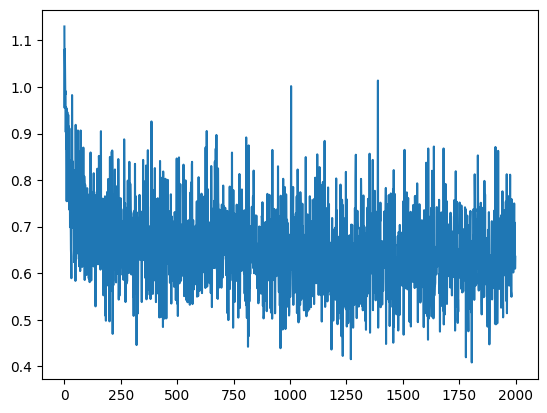

In [25]:
plt.plot(l_loss)

## 6. Evaluation

In [26]:
n_sample = 1000
d_sample = model.sample(n_sample=n_sample, device=device)

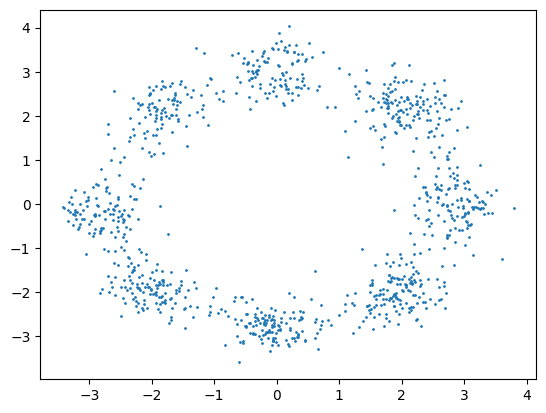

In [27]:
s = d_sample['sample'].detach()
plt.scatter(s[:, 0], s[:, 1], s=1)

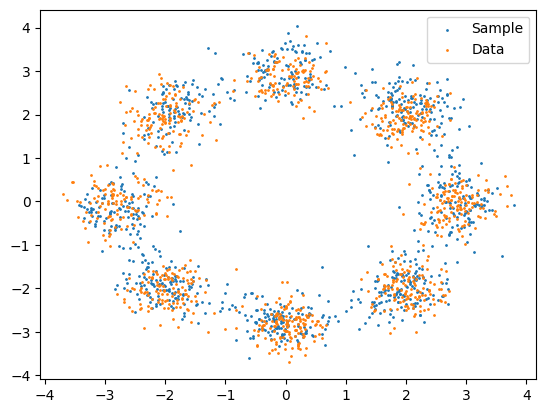

In [28]:
'''comparison'''
x_true = torch.tensor(sample2d(dataset, 1000, scale_factor=1.))

plt.scatter(s[:,0], s[:,1], s=1, label='Sample')
plt.scatter(x_true[:,0], x_true[:,1], s=1, label='Data')
plt.legend()

In [20]:
! pip install pot

In [29]:
'''for quantitative evaluation'''
import ot

n_sample = 10000
l_sample = []
for _ in range(10):
  with torch.no_grad():
    d_sample = model.sample(n_sample=1000, device=device)
  l_sample.append(d_sample['sample'].detach())

s = torch.cat(l_sample)
x_true = torch.tensor(sample2d(dataset, n_sample, scale_factor=1.))
w_dis = ot.sliced_wasserstein_distance(x_true, s, n_projections=1000, p=2).item()
print(w_dis)

0.1662300080060959
